In [53]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "/Users/elise/elisedonszelmann-lund/Masters_Utils/Pig_Data/pig2/Registration/Known_Trans/intra1/experiment_results/experiment_robustness.json"

with open(path, "r") as f:
    data = json.load(f)

tables = {}

for exp_name, exp_data in data.items():
    if exp_name == "_summary":
        continue

    rows = []
    for i in range(len(exp_data["runtime_sec"])):
        row = {
            "run": i,
            "runtime_sec": exp_data["runtime_sec"][i],
            "success": exp_data["success"][i],
        }

        for v in ["L1", "L2", "L3", "L4"]:
            row[f"init_{v}"]  = exp_data["initial_tre"][i][v]
            row[f"final_{v}"] = exp_data["final_tre"][i][v]

        rows.append(row)

    tables[exp_name] = pd.DataFrame(rows)

# collect all final TRE values across all experiments
all_final_vals = []

for df in tables.values():
    for v in ["L1", "L2", "L3", "L4"]:
        all_final_vals.extend(df[f"final_{v}"].dropna().values)

ymax = np.max(all_final_vals)
ymax = np.ceil(ymax * 2) / 2   # round up to nearest 0.5 mm

## PER-VERTEBRA SUMMARY TABLES

In [49]:
def make_summary_table(df):
    rows = []
    vertebrae = ["L1", "L2", "L3", "L4"]

    for v in vertebrae:
        final_vals = df[f"final_{v}"].dropna()

        median = np.round(np.median(final_vals), 2)
        q1 = np.percentile(final_vals, 25)
        q3 = np.percentile(final_vals, 75)
        iqr = np.round(q3 - q1, 2)

        success_rate = np.round(np.mean(final_vals < 2.0) * 100, 2)

        rows.append({
            "Vertebra": v,
            "Median TRE (mm)": median,
            "IQR (mm)": iqr,
            "Success Rate (%)": success_rate
        })

    return pd.DataFrame(rows)

summary_tables = {}


exp_titles = {
    "US_complete": "US Complete",
    "US_L3_blurry": "L3 Missing Data"
}

for exp_name, df in tables.items():
    summary_tables[exp_name] = make_summary_table(df)
    title = exp_titles.get(exp_name, exp_name) 
    print(f"\n{title}")
    print(summary_tables[exp_name].to_string(index=False))


US_complete_cal.nrrd
Vertebra  Median TRE (mm)  IQR (mm)  Success Rate (%)
      L1             1.48      0.68             83.33
      L2             1.55      0.60             90.00
      L3             0.84      0.31             96.67
      L4             1.32      0.31             93.33

US_full_L3_dropoutref_cal.nrrd
Vertebra  Median TRE (mm)  IQR (mm)  Success Rate (%)
      L1             1.54      0.55             80.00
      L2             2.38      0.62             23.33
      L3             1.99      0.73             50.00
      L4             1.24      0.42            100.00


## Condensed Summary Table

In [31]:
summary_rows = []

for exp_name, s in data["_summary"].items():
    row = {
        "experiment": exp_name,
        "success_rate": s["overall_success_rate"],
        "mean_runtime_sec": s["mean_runtime_sec"],
        "std_runtime_sec": s["std_runtime_sec"],
    }

    for v in ["L1", "L2", "L3", "L4"]:
        row[f"mean_final_{v}"] = s["mean_final_tre_per_vertebra"][v]
        row[f"std_final_{v}"] = s["std_final_tre_per_vertebra"][v]

    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df


,experiment,success_rate,mean_runtime_sec,std_runtime_sec,mean_final_L1,std_final_L1,mean_final_L2,std_final_L2,mean_final_L3,std_final_L3,mean_final_L4,std_final_L4
0,US_complete_cal.nrrd,0.666667,27.141580,0.610294,1.518181,0.513365,1.550299,0.413975,0.907046,0.352524,1.365235,0.349836
1,US_full_L3_dropoutref_cal.nrrd,0.133333,28.361527,0.490913,1.610845,0.479870,2.363580,0.467168,2.065593,0.616474,1.256152,0.274511


## BOX PLOTS

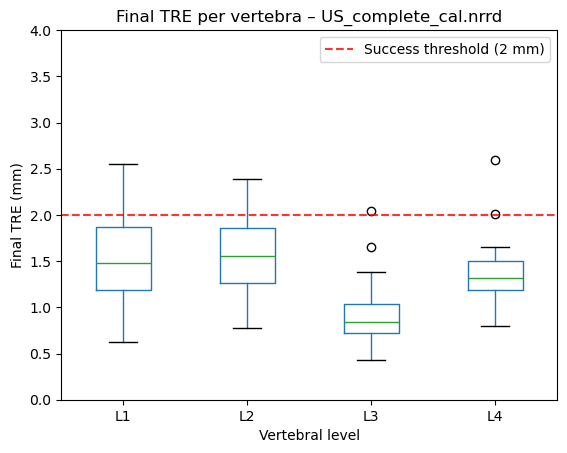

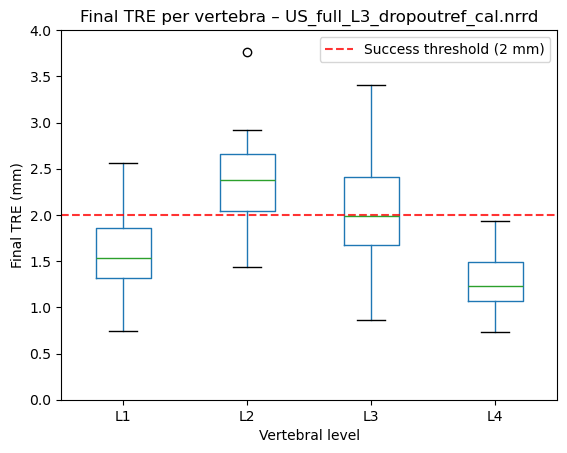

In [32]:
for exp_name, df in tables.items():
    plt.figure()

    box_df = df[[f"final_{v}" for v in ["L1","L2","L3","L4"]]]
    box_df.columns = ["L1", "L2", "L3", "L4"]

    box_df.boxplot()

    plt.xlabel("Vertebral level")
    plt.ylabel("Final TRE (mm)")
    plt.title(f"Final TRE per vertebra – {exp_name}")

    # identical y-limits
    plt.ylim(0, ymax)

    # 2 mm success threshold
    plt.axhline(
        2.0,
        linestyle="--",
        linewidth=1.5,
        alpha=0.8,
        color = "red",
        label="Success threshold (2 mm)"
    )

    plt.grid(False)
    plt.legend()
    plt.show()
